# MTH 5320 Homework 3
Nicholas Welsh

Dataset used: https://www.kaggle.com/datasets/puneet6060/intel-image-classification (put `seg_pred`, `seg_test`, `seg_train` in the same folder as this notebook)


## Problem 1: Custom CNN

note: only the best model's architecture is shown below, but all the prior models/baseline results were saved in checkpoints (see table). This is due to the fact that I manually changed hyperparameters during the 10 runs of problem 1. This has been altered and fixed for problem 2. 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display
import os, random

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Required for seeds (must go first or else it wont be reproducible)
def _seed_worker(worker_id):
    worker_info = torch.utils.data.get_worker_info()
    seed = worker_info.seed % 2**32
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

SEED = 8901

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
g_split = torch.Generator().manual_seed(SEED)
g_loader = torch.Generator().manual_seed(SEED)

In [5]:
# Creating model

In [6]:
class CNNModel(nn.Module):
    #initializing the model
  def __init__(self):
    super(CNNModel, self).__init__()
    #==== Block 1: 3 to 32 ====
    self.conv1a = nn.Conv2d(3, 32, 3, padding=1)
    self.bn1a = nn.BatchNorm2d(32)
    self.conv1b = nn.Conv2d(32, 32, 3, padding=1)
    self.bn1b = nn.BatchNorm2d(32)
    self.pool = nn.MaxPool2d(2, 2)     # 224 -> 112

    # ==== Block 2: 32 to 64 ====
    self.conv2a = nn.Conv2d(32, 64, 3, padding=1)
    self.bn2a = nn.BatchNorm2d(64)
    self.conv2b = nn.Conv2d(64, 64, 3, padding=1)
    self.bn2b = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(2, 2)     # 112 -> 56

    # ==== Block 3: 64 to 128 ====
    self.conv3a = nn.Conv2d(64, 128, 3, padding=1)
    self.bn3a = nn.BatchNorm2d(128)
    self.conv3b = nn.Conv2d(128, 128, 3, padding=1)
    self.bn3b = nn.BatchNorm2d(128)
    self.pool3 = nn.MaxPool2d(2, 2)     # 56 -> 28

    # ==== Head: GAP to Linear ====
    self.gap = nn.AdaptiveAvgPool2d(1)   # (N,128,1,1)
    self.fc = nn.Linear(128, 6)

  # forward pass (Applying pooling layers)
  def forward(self, x):
    # Block 1
    x = F.relu(self.bn1a(self.conv1a(x)))
    x = F.relu(self.bn1b(self.conv1b(x)))
    x = self.pool(x)

    # Block 2
    x = F.relu(self.bn2a(self.conv2a(x)))
    x = F.relu(self.bn2b(self.conv2b(x)))
    x = self.pool2(x)

    # Block 3
    x = F.relu(self.bn3a(self.conv3a(x)))
    x = F.relu(self.bn3b(self.conv3b(x)))
    x = self.pool3(x)

    # Head
    x = self.gap(x).view(x.size(0), -1) 
    x = self.fc(x)
    return x

In [7]:
print(CNNModel)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

<class '__main__.CNNModel'>


In [8]:
# Creating loss function / optimizer
CrossEntropy = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [9]:
# Train/Test/Val/Split
# Creating separate transformation pipelines for train/test


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Since we don't have a validation folder (pred folder is just unlabeled thus doesn't help with ImageFolder..) we need to split the training set to make val

full_train_dataset = ImageFolder('seg_train/seg_train', transform=train_transform)
test_dataset = ImageFolder('seg_test/seg_test', transform=test_transform)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size], generator=g_split)



# val dataset uses test transforms (basically a test set but during training)

val_dataset.dataset.transform = test_transform


train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=2,
    worker_init_fn=_seed_worker, generator=g_loader
)
val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False, num_workers=2,
    worker_init_fn=_seed_worker, generator=g_loader
)
test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=2,
    worker_init_fn=_seed_worker, generator=g_loader
)

In [10]:
# model Training and validation
EPOCHS = 100
best_val = float('inf')
best_acc = float('inf')
best_epoch = 0
bad_vals = 0
patience = 10


# arrays for the train/val loss graph
train_losses, val_losses, train_accs, val_accs = [], [], [], []


for epoch in range(EPOCHS):

    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = CrossEntropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    

    #model Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = CrossEntropy(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
            
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)
    
    
    
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
    train_accs.append(epoch_acc.item())
    val_accs.append(val_acc.item())

    if (epoch + 1) % 5 == 0 or epoch == 0 or (epoch + 1) == EPOCHS:
        print(f"===== Epoch {epoch+1}/{EPOCHS} =====")
        print(f"Train Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} Accuracy: {val_acc:.4f}")
        print("====================================")
    
    if(val_loss < best_val):
        best_val = val_loss
        best_acc = val_acc
        best_epoch = epoch + 1
        print(f"Best model so far on epoch {epoch+1}! saving...")
        torch.save(model.state_dict(), "cnn_run10_3blockgap.pth")
        # reset bad vals counter
        bad_vals = 0
    else: 
        bad_vals+=1
        print(f"No improvement for {bad_vals}/{patience} epochs")
        
    # early stopping
    if(patience == bad_vals):
        print("My patience is running low...")
        print(f"Final Train Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}")
        print(f"Final Val Loss: {val_loss:.4f} Accuracy: {val_acc:.4f}")
        print("====================================")
        print(f"Best Epoch: {best_epoch} ")
        print(f"Best Validation Accuracy: {best_acc:.4f}")
        print(f"Best Validation Loss: {best_val:.4f}")
        break

    # if it doesnt early stop
    if(epoch + 1) == EPOCHS:
        print(f"Training completed after {EPOCHS} epochs.")
        print(f"Final Train Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}")
        print(f"Final Val Loss: {val_loss:.4f} Accuracy: {val_acc:.4f}")
    


===== Epoch 1/100 =====
Train Loss: 1.4090 Accuracy: 0.4611
Val Loss: 1.1950 Accuracy: 0.5705
Best model so far on epoch 1! saving...
Best model so far on epoch 2! saving...
Best model so far on epoch 3! saving...
Best model so far on epoch 4! saving...
===== Epoch 5/100 =====
Train Loss: 0.9537 Accuracy: 0.6661
Val Loss: 0.8717 Accuracy: 0.6987
Best model so far on epoch 5! saving...
Best model so far on epoch 6! saving...
Best model so far on epoch 7! saving...
Best model so far on epoch 8! saving...
No improvement for 1/10 epochs
===== Epoch 10/100 =====
Train Loss: 0.7904 Accuracy: 0.7274
Val Loss: 0.7528 Accuracy: 0.7368
Best model so far on epoch 10! saving...
Best model so far on epoch 11! saving...
Best model so far on epoch 12! saving...
No improvement for 1/10 epochs
Best model so far on epoch 14! saving...
===== Epoch 15/100 =====
Train Loss: 0.7114 Accuracy: 0.7505
Val Loss: 0.6686 Accuracy: 0.7724
Best model so far on epoch 15! saving...
Best model so far on epoch 16! savi

In [11]:
# Testing
checkpoint = torch.load("cnn_run10_3blockgap.pth", weights_only=True)
model.load_state_dict(checkpoint)
model.eval()

test_loss = 0.0
test_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = CrossEntropy(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_loader.dataset)
test_acc = test_corrects.double() / len(test_loader.dataset)

print("=== Final Test Results ===")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


=== Final Test Results ===
Test Loss: 0.3840 | Test Accuracy: 0.8683


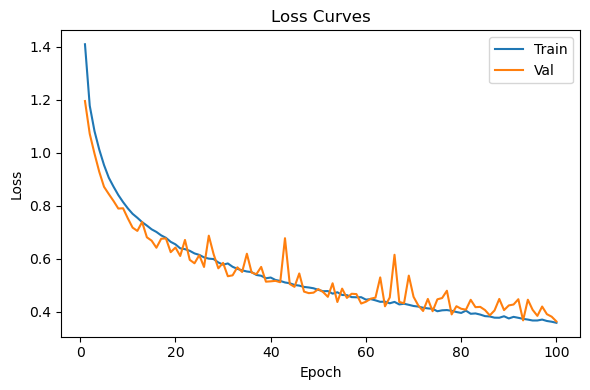

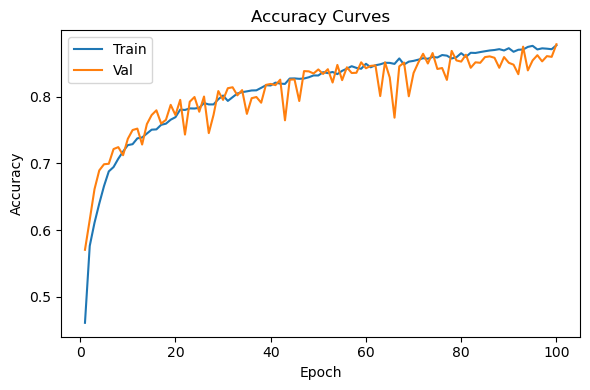

In [12]:
# === loss across epochs curve ===
epochs_seen = range(1, len(train_losses) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs_seen, train_losses, label="Train")
plt.plot(epochs_seen, val_losses, label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

plt.tight_layout()
plt.show()

# === accuracy across epochs curve ===
plt.figure(figsize=(6,4))
plt.plot(epochs_seen, train_accs, label="Train")
plt.plot(epochs_seen, val_accs,   label="Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()

plt.tight_layout()
plt.show()


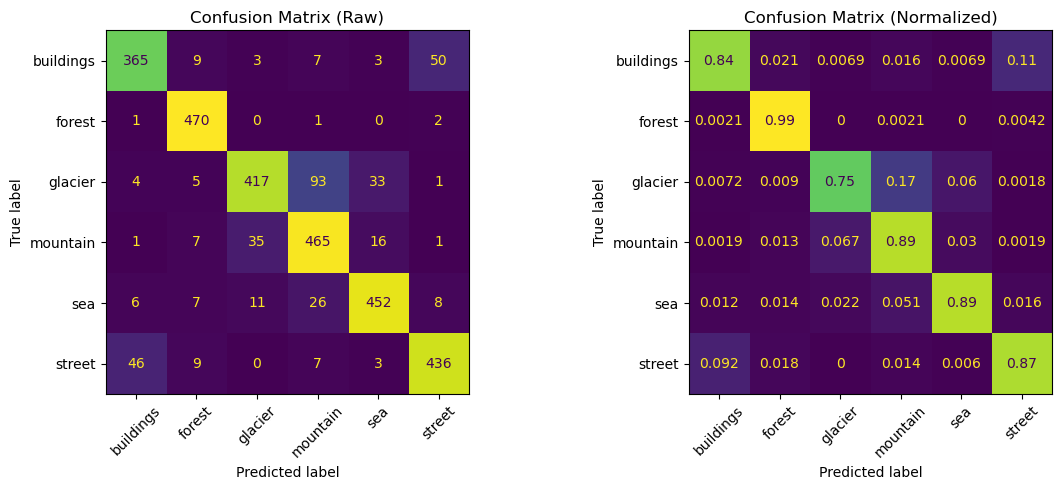


=== Per-class accuracy (TEST) ===


,class,support,accuracy
0,buildings,437,0.8352
1,forest,474,0.9916
2,glacier,553,0.7541
3,mountain,525,0.8857
4,sea,510,0.8863
5,street,501,0.8703


In [13]:
#=== Confusion matrix (raw + normalized) + per-class accuracy (TEST set) ===
model.eval()

try:
    class_names = full_train_dataset.classes
except Exception:
    try:
        class_names = test_dataset.classes
    except Exception:
        class_names = [str(i) for i in range(6)]

all_preds, all_labels = [], []
test_loss_cm, test_corrects_cm = 0.0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = CrossEntropy(logits, y)
        test_loss_cm += loss.item() * x.size(0)
        preds = logits.argmax(1)
        test_corrects_cm += (preds == y).sum().item()
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

y_true = torch.cat(all_labels).numpy()
y_pred = torch.cat(all_preds).numpy()

cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
cm_norm = cm.astype(float) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(ax=ax[0], colorbar=False, xticks_rotation=45)
ax[0].set_title("Confusion Matrix (Raw)")
ConfusionMatrixDisplay(cm_norm, display_labels=class_names).plot(ax=ax[1], colorbar=False, xticks_rotation=45)
ax[1].set_title("Confusion Matrix (Normalized)")
plt.tight_layout(); plt.show()

per_class_support = cm.sum(axis=1)
per_class_acc = (cm.diagonal() / np.maximum(per_class_support, 1)).round(4)

df_per_class = pd.DataFrame({
    "class": class_names,
    "support": per_class_support,
    "accuracy": per_class_acc
}).sort_values("class")

print("\n=== Per-class accuracy (TEST) ===")
display(df_per_class)

# fig.savefig("confusion_matrices.png", dpi=150, bbox_inches="tight")
# df_per_class.to_csv("per_class_accuracy.csv", index=False)


### Problem 1 Table & Analysis

| Run | Backbone/Arch         | **Change**                             | **Rationale**                                   | Hyperparams (opt/LR/batch/decay/drop/seed)  | Augmentations  | **Best Val Loss** | **Best Val Acc** | **Epoch @ Best** | **Final Test Acc** | **Notes / Observation**                    | **Checkpoint**           |
| --- | --------------------- | -------------------------------------- | ----------------------------------------------- | ------------------------------------------------- | -------------- | ----------------: | ---------------: | ---------------: | -----------------: | ------------------------------------------ | ------------------------ |
| 1   | 3-block CNN (9-18-36) | **Baseline**                           | Starting point for comparison                   | SGD / 1e-3 / 32 / 0 / 0  / 8901                 | resize + flip  |            0.6912 |           0.7689 |               58 |             0.7500 | Mild overfit, stable convergence           | `cnn_run1_baseline.pth`  |
| 2   | same                  | **LR lowered to 5e-4**                       | Test slower learning for stability              | SGD / 5e-4 / 32 / 0 / 0  / 8901                 | same           |                 0.7335 |                0.7382 |               86 |                  0.7273 | Converged slower, smoother loss curve      | `cnn_run2_lr5e4.pth`     |
| 3   | same                  | **Dropout (0.3)**                      | Reduce overfitting by disabling neurons         | SGD / 1e-3 / 32 / 0 / 0.3 / 8901               | same           |                 0.7265 |                0.7407 |                78 |                  0.7283 | Smaller train-val gap, val acc            | `cnn_run3_dropout03.pth` |
| 4   | same                  | **Weight Decay 1e-4**                  | Add L2 regularization to improve generalization | SGD / 1e-3 / 32 / 1e-4 / 0  / 8901              | same           |                 0.7442 |                0.7354 |                62 |                  0.7390 | Prevented overfit, steady training         | `cnn_run4_wd1e4.pth`     |
| 5   | same                  | **Batch 64**                           | Test smoother gradient updates                  | SGD / 1e-3 / 64 / 0 / 0  / 8901                 | same           |                 0.7218 |                0.7450 |                89 |                  0.7403 | Slightly slower learning, similar accuracy | `cnn_run5_b64.pth`       |
| 6   | 4-Block CNN (9-18-36-72)                  | **Added extra conv layer + larger feature maps** | Increase receptive field & feature depth         | SGD / 1e-3 / 32 / 0 / 0  / 8901 | same           |                 0.6392 |                0.7749 |                83 |                  0.7770 | Loss curve smoother after LR step          | `cnn_run6_4block.pth`     |
| 7   | same                  | **+ BatchNorm after each Conv**        | Improve stability and normalization             | SGD / 1e-3 / 32 / 0 / 0  / 8901                 | same           |                 0.6160 |                0.7767 |                13 |                  0.7773 | Faster convergence, minor val gain         | `cnn_run7_bn.pth`        |
| 8   | same                  | **Adam**    | Compare optimizer behavior vs SGD           | Adam / 1e-3 / 32 / 0 / 0 / 8901                 | Same |                 0.5920 |                0.7963 |                4 |                  0.7800 | Rapid Convergence but Extremely high overfitting after           | `cnn_run8_adam.pth`       |
| 9   | same                  | **SGD With Momentum 0.9**              | Compare default SGD with Momentum addition    | SGD / 1e-3 / 32 / 0 / 0  / 8901                 | same           |                 0.7031 |                0.7496 |                10 |                  0.7423 | Similar convergence to Adam with high overfitting after        | `cnn_run9_sgdmoment.pth`     |
| 10  | 3-block (32-64-128, 2*Conv) + Global Avg. Pool                  | **GAP head + wider block**                 | Significantly change architecture, notice differences             | SGD / 1e-2 / 32 / 0 / 0  / 8901             | same           |                 0.3642 |                0.8786 |                100 |                  0.8683 | Best overall model, low signs of overfitting            | `cnn_run10_3blockgap.pth`      |

After much research, during my 10th run, I found that there were several naive mistakes which brought the model's performance down during training. These include:
- Very small channel widths (9/18/36), therefore a limited feature capacity
- Aggressive pooling after every conv (I for one thought this was the norm, my bad lol), meaning I downsample quickly, thereby letting the model have less room to extract rich features at the same scale.
- Huge flatten, and big Foward-connected head, specifically:
  - Flatten size = 36 * 28 * 28 = 28,224 features
  - First Forward-connected layer parameters: 28,224 * 48 = 1.35 million
  - Convolutional layers only had about 7.6k parameters
    - Result? about 99% of parameters sit in the classifier, which is easy to overfit and doesn't help learn good spacial features.
   
The code of the old architecture (used for the first 9 runs) is below:
```python
class CNNModel(nn.Module):
    #initializing the model
  def __init__(self):
    super(CNNModel, self).__init__()
    self.conv1 = nn.Conv2d(3, 9, 3, padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(9, 18, 3, padding=1)
    self.pool2 = nn.MaxPool2d(2,2)
    self.conv3 = nn.Conv2d(18, 36, 3, padding=1)
    self.fc1 = nn.Linear(36 * 28 * 28, 48)
    self.fc2 = nn.Linear(48, 24)
    self.fc3 = nn.Linear(24, 6)

    # #dropout
    # self.dropout1 = nn.Dropout(0.3)
    # self.dropout2 = nn.Dropout(0.3)

  # forward pass (Applying pooling layers)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(x.size(0), -1)
      
    x = F.relu(self.fc1(x))
    # x = self.dropout1(x)
    x = F.relu(self.fc2(x))
    # x = self.dropout2(x)
    x = self.fc3(x)
    return x
```

The new architecture is made out of 3 main blocks, each containing two convolutional layers. From previous runs, I used `BatchNorm` to stabilize training through improved generalization. The biggest change was the wider channels (32/64/128) which gives the model enough capacity to model more specific parts of the picture.

Finally, the use of a Global Average Pool (GAP) is used via PyTorch's `AdaptiveAvgPool2d` function.
- The Forward-connected layer parameters now: 128 * 6 = 768, a far cry from 1.35 million.
  - In return, the convolutional layer holds most of the parameters now, meaning capacity is spent on FEATURE LEARNING, not a large classifier as before.
 
The results are shown in Run 10 of the table. As I was running it my PC was slower than the last 9 runs, in my head I was thinking "now this is something interesting!"


## Problem 2: Transfer Learning using `torchvision` with ResNet-18

In this section I fine-tune a pretrained ResNet-18 backbone from
`torchvision.models` on our Intel image classification dataset.


In [15]:
import torchvision.models as models

def create_resnet18(num_classes=6, pretrained=True):
    weights = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
    model = models.resnet18(weights=weights)

    # Replace classifier head
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model


def set_finetune_mode(model, mode="linear_probe"):
    # for the modes there are 3 choices:
    # 'linear_probe': freezes all conv layers, train only final FC
    # 'layer4': unfreeze layer4 + FC
    # 'full': unfreeze entire model

    # by default, freeze everything
    for p in model.parameters():
        p.requires_grad = False

    if (mode == "linear_probe"):
        for p in model.fc.parameters():
            p.requires_grad = True

    elif (mode == "layer4"):
        for p in model.layer4.parameters():
            p.requires_grad = True
        for p in model.fc.parameters():
            p.requires_grad = True

    elif (mode == "full"):
        for p in model.parameters():
            p.requires_grad = True

### Comparison of Training Setup in problem 1 vs problem 2

Although Problems 1 and 2 use the same Intel image dataset, dataloaders, and evaluation metrics (cross-entropy loss with accuracy on train/val/test), the training setup in problem 2 is structurally different from problem 1 in several important ways:

1. **Freezing vs training all layers.**  
   - Before, Every parameter in the custom CNN is always trainable. Now, I explicitly control which parts of ResNet-18 are trainable via `finetune_mode`:
     - `linear_probe`: freeze all conv layers and train only the final FC head.  
     - `layer4`: unfreeze only the last residual block + head.  
     - `full`: unfreeze the entire network.  
     This lets me systematically study different fine-tuning strategies.

2. **Parameter groups and learning rates.**  
   - before: I use a single learning rate for all parameters: one `optimizer` with one LR.  
   - now: I separate parameters into head and backbone groups and assign different learning rates (`lr_head` vs `lr_backbone`). This is important as I've researched in transfer learning, where the pretrained backbone often uses a smaller LR than the newly initialized head.

3. **Training loop structure (script vs function).**  
   - before: Training is written as a single top-level script:
     - Global variables (`EPOCHS`, `patience`, `train_losses`, `val_losses`, etc.).  
     - One long loop that saves the best checkpoint (`cnn_run10_3blockgap.pth`) and prints progress every few epochs.  
   - now: I refactor training into a reusable function:
     ```python
     def train_transfer_run(run_name, finetune_mode, lr_head, lr_backbone, ...):
         ...
         return history
     ```
     Each P2 experiment (T1–T10) calls this function with one hyperparameter changed, which makes it much easier to run and document the $\geq$ 10 transfer-learning runs.

4. **Early stopping and history tracking.**  
   - before: 
     - Early stopping logic is managed manually with `best_val`, `bad_vals`, and `patience`.  
     - I store global lists `train_losses`, `val_losses`, `train_accs`, `val_accs` outside the loop.  
   - now:  
     - Early stopping is still based on validation loss, but it lives *inside* `train_transfer_run` with local `best_val_loss` and `bad_epochs`.  
     - I store the per-epoch metrics in a per-run `history` dictionary that gets returned:
       ```python
       history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
       ```
       which makes it significantly easier to plot learning curves and compare runs.

5. **Checkpoint naming and usage.**  
   - before: I save a single main checkpoint for the best custom CNN as `cnn_run10_3blockgap.pth`.  
   - now: Every transfer-learning run saves its own checkpoint using the `run_name`, which I later reuse for ensembling.

The function-based training interface to run and analyze multiple transfer-learning configurations systematically was one of my main accomplishments during this part. In problem 1 I found manually changing the model's architecture and weights after every run to be brittle and too labourious, which is why I changed my training strategy for this problem.


In [41]:
def train_transfer_run(
    run_name,
    finetune_mode="linear_probe",
    lr_head=1e-3,
    lr_backbone=1e-4,
    weight_decay=0.0,
    num_epochs=25,
    patience=5,
):

    model = create_resnet18().to(device)
    set_finetune_mode(model, finetune_mode)

    # make separate parameter groups so head and backbone can have different Learning rates
    head_params = []
    backbone_params = []
    for name, p in model.named_parameters():
        if (not p.requires_grad):
            continue
        if (name.startswith("fc.")):
            head_params.append(p)
        else:
            backbone_params.append(p)

    param_groups = []
    if backbone_params:
        param_groups.append({"params": backbone_params, "lr": lr_backbone})
    if head_params:
        param_groups.append({"params": head_params, "lr": lr_head})

    #loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(param_groups, momentum=0.9, weight_decay=weight_decay)

    best_val_loss = float("inf")
    best_state = None
    bad_epochs = 0

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        # training the model
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(1)
            running_loss += loss.item() * x.size(0)
            running_corrects += (preds == y).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)

        #model validation
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = criterion(outputs, y)
                preds = outputs.argmax(1)

                val_loss += loss.item() * x.size(0)
                val_corrects += (preds == y).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects / len(val_loader.dataset)

        
        # save history
        history["train_loss"].append(epoch_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(epoch_acc)
        history["val_acc"].append(val_acc)

        #====== print statements ========

        print(
            f"[Current Model: {run_name}] Epoch {epoch+1}/{num_epochs} | "
            f"train loss: {epoch_loss:.4f} / accuracy: {epoch_acc:.4f} | "
            f"val loss: {val_loss:.4f} / accuracy: {val_acc:.4f}"
        )

        # Early stopping on val loss
        if (val_loss < best_val_loss):
            best_val_loss = val_loss
            best_state = model.state_dict()
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"[Current Model: {run_name}] Early stopping at epoch {epoch+1}")
                break

    # Load best weights and save checkpoint
    model.load_state_dict(best_state)
    ckpt_name = f"resnet18_{run_name}.pth"
    torch.save(model.state_dict(), ckpt_name)
    print(f"[Current Model: {run_name}] Saved best model to {ckpt_name} (best val loss={best_val_loss:.4f})")
    print("===================================================")

    return history


In [17]:
# R1: Baseline model (linear probing)
hist_R1 = train_transfer_run(
    run_name="R1_linear_probe_baseline",
    finetune_mode="linear_probe",
    lr_head=1e-3,
    lr_backbone=0.0,
    weight_decay=0.0,
)
# R2: different learning rate (5e-4 to 1e-3) vs R1
hist_R2 = train_transfer_run(
    run_name="R2_linear_probe_lr5e4",
    finetune_mode="linear_probe",
    lr_head=5e-4,
    lr_backbone=0.0,
)

# R3: add weight decay (R2) vs R1
hist_R3 = train_transfer_run(
    run_name="R3_linear_probe_wd1e4",
    finetune_mode="linear_probe",
    # same as T1
    lr_head=1e-3, 
    lr_backbone=0.0,
    # only change
    weight_decay=1e-4, 
)

# R4: longer patience vs R1 (train longer before early stopping)
hist_R4 = train_transfer_run(
    run_name="R4_linear_probe_pat10",
    finetune_mode="linear_probe",
    lr_head=1e-3,
    lr_backbone=0.0,
    weight_decay=0.0,
    # same max epochs
    num_epochs=25,
    # only change (from 5)
    patience=10,
)

# R5: unfreeze layer4 (have partial finetuning) vs R1
hist_R5 = train_transfer_run(
    run_name="R5_layer4_finetune",
    # only change: fine-tuning mode
    finetune_mode="layer4",
    lr_head=1e-3,
    lr_backbone=1e-4,
    weight_decay=0.0,
)

# R6: smaller backbone learning rate vs R5
hist_R6 = train_transfer_run(
    run_name="R6_layer4_ft_lrbb5e5",
    finetune_mode="layer4",
    lr_head=1e-3,
    # only change (from 1e-4)
    lr_backbone=5e-5,
    weight_decay=0.0,
)

# R7: smaller head learning rate vs R6
hist_R7 = train_transfer_run(
    run_name="R7_layer4_ft_lrhead5e4",
    finetune_mode="layer4",
    #only change (from 1e-3)
    lr_head=5e-4,
    lr_backbone=5e-5,
    weight_decay=0.0,
)

# R8: full fine-tuning (all layers) vs R5/6/7
hist_R8 = train_transfer_run(
    run_name="R8_full_finetune",
    # only change: fine-tuning mode
    finetune_mode="full", 
    lr_head=1e-3,
    lr_backbone=1e-4,
    weight_decay=0.0,
)

# R9: add weight decay in full fine-tuning vs R8
hist_R9 = train_transfer_run(
    run_name="R9_full_ft_wd1e4",
    finetune_mode="full",
    lr_head=1e-3,
    lr_backbone=1e-4,
    # only change
    weight_decay=1e-4, 
)

# R10: allow more epochs in full fine-tuning vs R9
hist_R10 = train_transfer_run(
    run_name="R10_full_ft_epoch50",
    finetune_mode="full",
    lr_head=1e-3,
    lr_backbone=1e-4,
    weight_decay=1e-4,
    #only change (from 25)
    num_epochs=50,
    patience=10,
)



[Current Model: R1_linear_probe_baseline] Epoch 1/25 | train loss: 0.5690 / accuracy: 0.8140 | val loss: 0.3192 / accuracy: 0.9056
[Current Model: R1_linear_probe_baseline] Epoch 2/25 | train loss: 0.3387 / accuracy: 0.8846 | val loss: 0.2803 / accuracy: 0.9110
[Current Model: R1_linear_probe_baseline] Epoch 3/25 | train loss: 0.3112 / accuracy: 0.8928 | val loss: 0.2662 / accuracy: 0.9156
[Current Model: R1_linear_probe_baseline] Epoch 4/25 | train loss: 0.2975 / accuracy: 0.8937 | val loss: 0.2597 / accuracy: 0.9131
[Current Model: R1_linear_probe_baseline] Epoch 5/25 | train loss: 0.2862 / accuracy: 0.8966 | val loss: 0.2613 / accuracy: 0.9117
[Current Model: R1_linear_probe_baseline] Epoch 6/25 | train loss: 0.2839 / accuracy: 0.8986 | val loss: 0.2646 / accuracy: 0.9060
[Current Model: R1_linear_probe_baseline] Epoch 7/25 | train loss: 0.2832 / accuracy: 0.8977 | val loss: 0.2622 / accuracy: 0.9085
[Current Model: R1_linear_probe_baseline] Epoch 8/25 | train loss: 0.2696 / accurac

In [59]:
# ==== TESTING PROBLEM 2 MODEL (best run R10) ====

BEST_RUN = "R10_full_ft_epoch50"
ckpt_path = f"resnet18_{BEST_RUN}.pth"

# Recreate the same architecture used in training
model_tl = create_resnet18().to(device)
checkpoint = torch.load(ckpt_path, weights_only=True)
model_tl.load_state_dict(checkpoint)
model_tl.eval()

criterion = nn.CrossEntropyLoss()

test_loss = 0.0
test_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_tl(inputs)
        loss = criterion(outputs, labels)

        preds = outputs.argmax(1)
        test_loss += loss.item() * inputs.size(0)
        test_corrects += (preds == labels).sum().item()

test_loss = test_loss / len(test_loader.dataset)
test_acc = test_corrects / len(test_loader.dataset)

print("=== problem 2 Final Test Results (Transfer Learning) ===")
print(f"Run: {BEST_RUN}")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


=== problem 2 Final Test Results (Transfer Learning) ===
Run: R10_full_ft_epoch50
Test Loss: 0.2152 | Test Accuracy: 0.9293


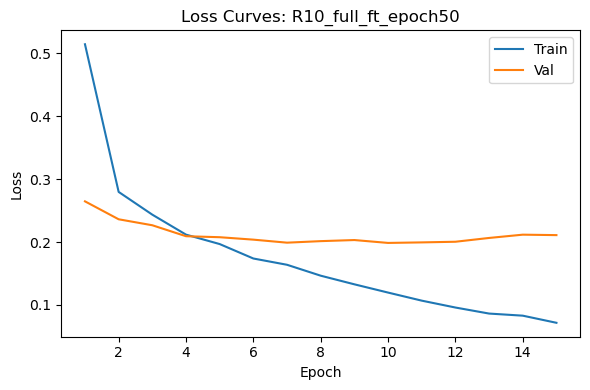

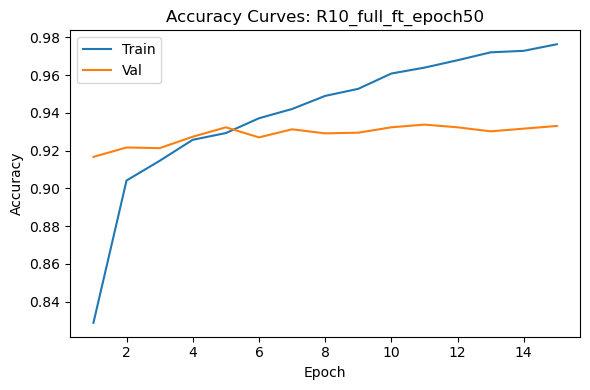

In [60]:
# ==== problem 2 curves for a single run (R10) ====

history = hist_R8

epochs_seen = range(1, len(history["train_loss"]) + 1)

# loss + accuracy curves
plt.figure(figsize=(6, 4))
plt.plot(epochs_seen, history["train_loss"], label="Train")
plt.plot(epochs_seen, history["val_loss"],   label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss Curves: {BEST_RUN}")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs_seen, history["train_acc"], label="Train")
plt.plot(epochs_seen, history["val_acc"],   label="Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Accuracy Curves: {BEST_RUN}")
plt.legend()
plt.tight_layout()
plt.show()



[Confusion Matrix Eval] Test Loss: 0.2152 | Test Acc: 0.9293


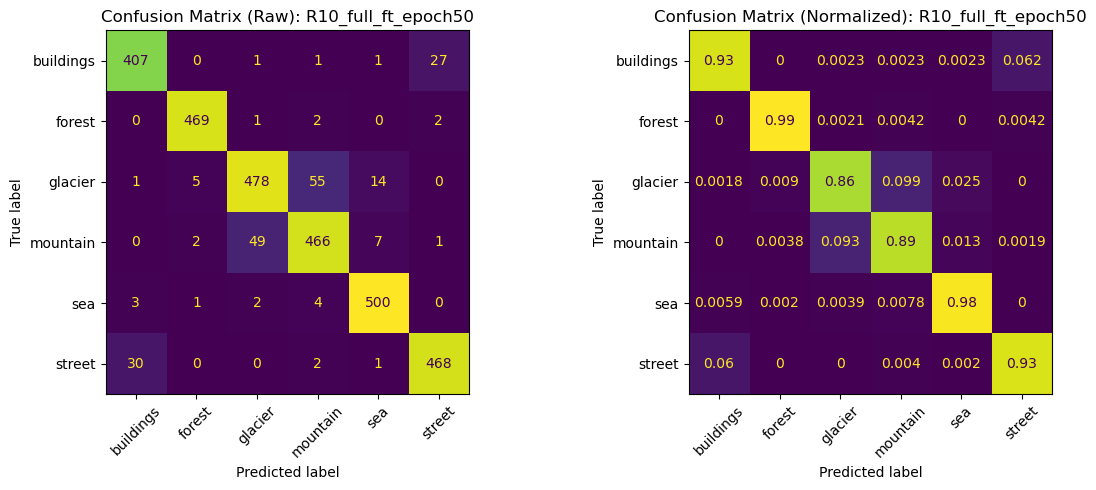


=== Per-class accuracy (TEST) ===


,class,support,accuracy
0,buildings,437,0.9314
1,forest,474,0.9895
2,glacier,553,0.8644
3,mountain,525,0.8876
4,sea,510,0.9804
5,street,501,0.9341


In [61]:
# === problem 2 Confusion matrix + per-class accuracy on TEST ===

model_tl.eval()

try:
    class_names = full_train_dataset.classes
except Exception:
    try:
        class_names = test_dataset.classes
    except Exception:
        class_names = [str(i) for i in range(6)]

all_preds, all_labels = [], []
test_loss_cm, test_corrects_cm = 0.0, 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model_tl(x)
        loss = criterion(logits, y)

        test_loss_cm += loss.item() * x.size(0)
        preds = logits.argmax(1)
        test_corrects_cm += (preds == y).sum().item()
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

test_loss_cm = test_loss_cm / len(test_loader.dataset)
test_acc_cm = test_corrects_cm / len(test_loader.dataset)
print(f"\n[Confusion Matrix Eval] Test Loss: {test_loss_cm:.4f} | Test Acc: {test_acc_cm:.4f}")

y_true = torch.cat(all_labels).numpy()
y_pred = torch.cat(all_preds).numpy()

cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
cm_norm = cm.astype(float) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(ax=ax[0], colorbar=False, xticks_rotation=45)
ax[0].set_title(f"Confusion Matrix (Raw): {BEST_RUN}")
ConfusionMatrixDisplay(cm_norm, display_labels=class_names).plot(ax=ax[1], colorbar=False, xticks_rotation=45)
ax[1].set_title(f"Confusion Matrix (Normalized): {BEST_RUN}")
plt.tight_layout()
plt.show()

per_class_support = cm.sum(axis=1)
per_class_acc = (cm.diagonal() / np.maximum(per_class_support, 1)).round(4)

df_per_class = pd.DataFrame({
    "class": class_names,
    "support": per_class_support,
    "accuracy": per_class_acc
}).sort_values("class")

print("\n=== Per-class accuracy (TEST) ===")
display(df_per_class)


### Problem 2: Transfer Learning Summary Metrics & Discussion

| Run | Name                          | Backbone / FT Mode           | lr_head | lr_backbone | weight decay    | epochs (max) | patience | Best Val Loss | Best Val Acc | Epoch @ Best Loss | Checkpoint                                  |
| --- | ----------------------------- | ---------------------------- | ------- | ----------- | ----- | ------------ | -------- | -------------:| ------------:| -----------------:| ------------------------------------------- |
| 1   | R1_linear_probe_baseline      | ResNet-18, linear probe      | 1e-3    | –           | 0     | 25           | 5        | 0.2382        | 0.9177       | 21                | `resnet18_R1_linear_probe_baseline.pth`     |
| 2   | R2_linear_probe_lr5e4         | ResNet-18, linear probe      | 5e-4    | –           | 0     | 25           | 5        | 0.2419        | 0.9181       | 23                | `resnet18_R2_linear_probe_lr5e4.pth`        |
| 3   | R3_linear_probe_wd1e4         | ResNet-18, linear probe      | 1e-3    | –           | 1e-4  | 25           | 5        | 0.2385        | 0.9181       | 17                | `resnet18_R3_linear_probe_wd1e4.pth`        |
| 4   | R4_linear_probe_pat10         | ResNet-18, linear probe      | 1e-3    | –           | 0     | 25           | 10       | 0.2383        | 0.9160       | 24                | `resnet18_R4_linear_probe_pat10.pth`        |
| 5   | R5_layer4_finetune            | ResNet-18, layer4 + head     | 1e-3    | 1e-4        | 0     | 25           | 5        | 0.2040        | 0.9327       | 17                | `resnet18_R5_layer4_finetune.pth`           |
| 6   | R6_layer4_ft_lrbb5e5          | ResNet-18, layer4 + head     | 1e-3    | 5e-5        | 0     | 25           | 5        | 0.2056        | 0.9320       | 20                | `resnet18_R6_layer4_ft_lrbb5e5.pth`         |
| 7   | R7_layer4_ft_lrhead5e4        | ResNet-18, layer4 + head     | 5e-4    | 5e-5        | 0     | 25           | 5        | 0.1996        | 0.9320       | 23                | `resnet18_R7_layer4_ft_lrhead5e4.pth`       |
| 8   | R8_full_finetune              | ResNet-18, full fine-tuning  | 1e-3    | 1e-4        | 0     | 25           | 5        | 0.1986        | 0.9338       | 10                | `resnet18_R8_full_finetune.pth`             |
| 9   | R9_full_ft_wd1e4              | ResNet-18, full fine-tuning  | 1e-3    | 1e-4        | 1e-4  | 25           | 5        | 0.1981        | 0.9320       | 9                 | `resnet18_R9_full_ft_wd1e4.pth`             |
| 10  | R10_full_ft_epoch50           | ResNet-18, full fine-tuning  | 1e-3    | 1e-4        | 1e-4  | 50           | 5        | 0.1975        | 0.9348       | 6                 | `resnet18_R10_full_ft_epoch50.pth`          |

Starting from a ResNet-18 linear probe baseline seemed the best pre-trained model to use for this problem, due to the good tradeoff between the capacity of the model and compute. It was deep enough to learn features from ImageNet but still small enough to train and fine-tune quickly for this homework. Starting with a linear probe (freezing the backbone and training only a new classifier head) was something I found out after researching on transfer learning, letting me measure how good the pretrained features are on the intel dataset before I invest more time on expensive full finetuning. Once I had that baseline, I could unfreeze more layers (you can see with layer4, then the whole network) and see how much imrovement comes from adapting the backbone vs tuning only the head.


The first set of runs already gave strong performance, 91-92% validation accuracy, but they consistently plateaued with val losses around 0.24. Tweaking only the head at the start and adding small weight decay gave very minimal gains, which suggested that the backbone I froze was the one limiting performance more than the classifier regularization.

The next set of runs (R5-R7) froze the `layer4` along with the head, producing the biggest jump in performance, with validation loss dropping to 0.20 and accuracy moving towards 93%. The models also converged faster, meaning that updating only the last block was enough to adapt the high-level features to our dataset without severe overfitting, which were issues that I had in my own custom-built CNN.

The final ones were full fine-tuning runs (R8-R10), which gave a smaller but consistent improvement over layer4 tuning. All of the three fully trained models achieved, as expected, the lowest validation losses at 0.198, and the highest validation accuracies, with `R10_full_ft_epoch50` reaching 0.1975 val loss and 0.9348 val accuracy. Weight decay helped keep the validation loss from drifting up as the training accuracy approached 98%. 

My main takeaway for this problem is that moving froma pure linear probe to selectively unfreezing layers provides the largest benefit, and full finetuning with a pretrained backbone plus some regularization squeezed out the last 1-2% of accuracy. 

Based on this, I selected `R10,` `R5,` `R8,` and `R9` as my best transfer-learning models for the ensemble experiments in Problem 3.

## Problem 3: Model Ensembling and Performance Integration

For the ensemble experiments, I use the best custom CNN from Problem 1 (`cnn_run10_3blockgap.pth`) together with the four strongest ResNet-18 transfer models from Problem 2 (`R5_layer4_finetune`, `R8_full_finetune`, `R9_full_ft_wd1e4`, and `R10_full_ft_epoch50`). These checkpoints were selected because they achieve the highest validation accuracy and lowest validation loss among all runs, while also providing some architectural diversity. One fine-tuned model (layer4 + head) and three fully fine-tuned ResNets with slightly different regularization settings. This satisfies the requirement of using at least five high-performing checkpoints and mixing Custom CNN and Transfer Learning models.

I evaluate two main ensembling strategies, both based on soft voting over class probabilities. First, I test uniform-weighted soft ensembles (part A), including a CNN-only ensemble (E1), a ResNet-only ensemble (E2), and a mixed ensemble combining all five models (E3). Second, I construct a validation-accuracy weighted mixed ensemble (part B) (E4), where each model's contribution is proportional to its validation accuracy from Problems 1-2. This lets me compare whether simply averaging strong models is enough, or whether weighting them by validation performance yields additional gains in overall accuracy and per-class stability.


In [62]:
criterion = nn.CrossEntropyLoss()

# ===== build architectures ====

def build_cnn():
    model = CNNModel()
    return model.to(device)

def build_resnet18(num_classes=6):
    model = models.resnet18(weights=None)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model.to(device)

def load_model(arch, ckpt_path):
    if (arch == "cnn"):
        model = build_cnn()
    elif (arch == "resnet18"):
        model = build_resnet18(num_classes=6)

    state = torch.load(ckpt_path, map_location=device, weights_only=True) #remove the pickle error thingy
    model.load_state_dict(state)
    model.eval()
    return model

In [63]:
# loading the models
model_specs = {
    "cnn_best": ("cnn", "cnn_run10_3blockgap.pth"),
    "resnet_R5_layer4": ("resnet18", "resnet18_R5_layer4_finetune.pth"),
    "resnet_R8_full": ("resnet18", "resnet18_R8_full_finetune.pth"),
    "resnet_R9_full": ("resnet18", "resnet18_R9_full_ft_wd1e4.pth"),
    "resnet_R10_full": ("resnet18", "resnet18_R10_full_ft_epoch50.pth"),
}

models_dict = {
    name: load_model(arch, ckpt)
    for name, (arch, ckpt) in model_specs.items()
}

#list models
print("Loaded models:")
for name in models_dict:
    print("  ", name)

Loaded models:
   cnn_best
   resnet_R5_layer4
   resnet_R8_full
   resnet_R9_full
   resnet_R10_full


In [64]:
# ===== helpers to evaluate single models and soft voting ensembles =====

# return (loss, accuracy, preds_np, labels_np) on a given loader
def eval_single(model, loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(dim=1)

            total_loss += loss.item() * y.size(0)
            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    avg_loss = total_loss / total_samples
    acc = total_correct / total_samples
    
    return avg_loss, acc, all_preds, all_labels

# soft voting ensemble on a given loader
def eval_soft_ensemble(model_names, loader, weights=None):
    if weights is None:
        w = 1.0 / len(model_names)
        weights = {name: w for name in model_names}

    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            ens_probs = None

            for name in model_names:
                logits = models_dict[name](x)
                probs = torch.softmax(logits, dim=1)
                if (ens_probs is None):
                    ens_probs = weights[name] * probs
                else:
                    ens_probs += weights[name] * probs

            preds = ens_probs.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    acc = total_correct / total_samples

    # return accuracy all the predicrtions/labels
    return acc, all_preds, all_labels

# return confusion matrix and per-class accuracy DataFrame
def per_class_summary(labels, preds, class_names=None):
    cm = confusion_matrix(labels, preds)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    if class_names is None:
        class_names = [f"class_{i}" for i in range(len(per_class_acc))]
    df = pd.DataFrame({
        "class": class_names,
        "per_class_accuracy": per_class_acc,
        "support": cm.sum(axis=1)
    })
    return cm, df

# get class names from dataset objects
try:
    class_names = test_dataset.classes
except NameError:
    try:
        class_names = full_train_dataset.classes
    except NameError:
        class_names = None

In [65]:
# ===== 1. evaluate each model individually (including the val accuracy for weighting) =====

single_results = {}
val_accs = {}

print("\nSingle-model performance:")
for name, model in models_dict.items():
    val_loss, val_acc, _, _ = eval_single(model, val_loader)
    test_loss, test_acc, _, _ = eval_single(model, test_loader)
    single_results[name] = {
        "val_loss": val_loss,
        "val_acc":  val_acc,
        "test_loss": test_loss,
        "test_acc":  test_acc,
    }
    val_accs[name] = val_acc
    print(f"{name:15s} | val_acc={val_acc:.4f} | test_acc={test_acc:.4f}")

single_df = pd.DataFrame(single_results).T
display(single_df)


Single-model performance:
cnn_best        | val_acc=0.8786 | test_acc=0.8683
resnet_R5_layer4 | val_acc=0.9281 | test_acc=0.9263
resnet_R8_full  | val_acc=0.9330 | test_acc=0.9257
resnet_R9_full  | val_acc=0.9309 | test_acc=0.9277
resnet_R10_full | val_acc=0.9309 | test_acc=0.9293


,val_loss,val_acc,test_loss,test_acc
cnn_best,0.364180,0.878561,0.384010,0.868333
resnet_R5_layer4,0.215811,0.928063,0.216371,0.926333
resnet_R8_full,0.210938,0.933048,0.221924,0.925667
resnet_R9_full,0.210002,0.930912,0.207658,0.927667
resnet_R10_full,0.210870,0.930912,0.215188,0.929333


In [66]:
# ===== 2. define ensembles (cnn only, resnet only, Mixed) =====

cnn_models = ["cnn_best"]
resnet_models = ["resnet_R5_layer4", "resnet_R8_full",
                 "resnet_R9_full", "resnet_R10_full"]

#specifically for (part B)
mixed_models = cnn_models + resnet_models

#ensemble lists

ensembles = {}

# (part A) Uniform soft voting
for name_list, tag in [
    (cnn_models, "E1_cnn_uniform"),
    (resnet_models, "E2_resnet_uniform"),
    (mixed_models, "E3_mixed_uniform"),
]:
    acc, preds, labels = eval_soft_ensemble(name_list, test_loader, weights=None)
    cm, df_pc = per_class_summary(labels, preds, class_names)
    ensembles[tag] = {
        "members": name_list,
        "strategy": "uniform_soft",
        "test_acc": acc,
        "cm": cm,
        "per_class_df": df_pc,
    }
    #print out test accuracy
    print(f"\n{tag}: test_acc = {acc:.4f}")
    
    display(df_pc)

# (part B) mixed ensemble with val accuracy weighting
sum_val = sum(val_accs[name] for name in mixed_models)
weights_mixed = {name: val_accs[name] / sum_val for name in mixed_models}
acc, preds, labels = eval_soft_ensemble(mixed_models, test_loader, weights=weights_mixed)
cm, df_pc = per_class_summary(labels, preds, class_names)
ensembles["E4_mixed_val_weighted"] = {
    "members": mixed_models,
    "strategy": "val_weighted_soft",
    "weights": weights_mixed,
    "test_acc": acc,
    "cm": cm,
    "per_class_df": df_pc,
}

#print out tables/weights used
print(f"\nE4_mixed_val_weighted: test_acc = {acc:.4f}")
print("Weights:", weights_mixed)

display(df_pc)


E1_cnn_uniform: test_acc = 0.8683


,class,per_class_accuracy,support
0,buildings,0.835240,437
1,forest,0.991561,474
2,glacier,0.754069,553
3,mountain,0.885714,525
4,sea,0.886275,510
5,street,0.870259,501



E2_resnet_uniform: test_acc = 0.9297


,class,per_class_accuracy,support
0,buildings,0.919908,437
1,forest,0.995781,474
2,glacier,0.862568,553
3,mountain,0.891429,525
4,sea,0.976471,510
5,street,0.942116,501



E3_mixed_uniform: test_acc = 0.9323


,class,per_class_accuracy,support
0,buildings,0.919908,437
1,forest,0.997890,474
2,glacier,0.864376,553
3,mountain,0.895238,525
4,sea,0.978431,510
5,street,0.948104,501



E4_mixed_val_weighted: test_acc = 0.9323
Weights: {'cnn_best': 0.19092949462115935, 'resnet_R5_layer4': 0.20168717591517685, 'resnet_R8_full': 0.20277068338363904, 'resnet_R9_full': 0.20230632304001236, 'resnet_R10_full': 0.20230632304001236}


,class,per_class_accuracy,support
0,buildings,0.919908,437
1,forest,0.997890,474
2,glacier,0.864376,553
3,mountain,0.893333,525
4,sea,0.978431,510
5,street,0.950100,501


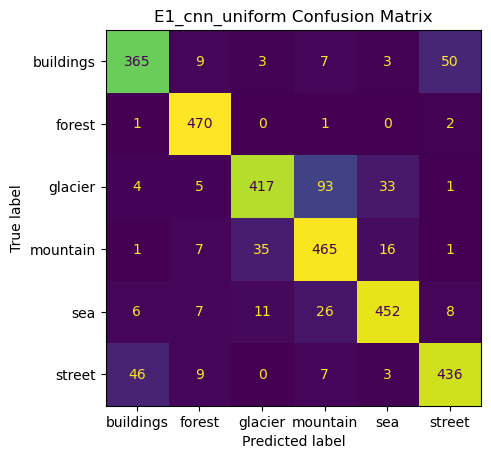

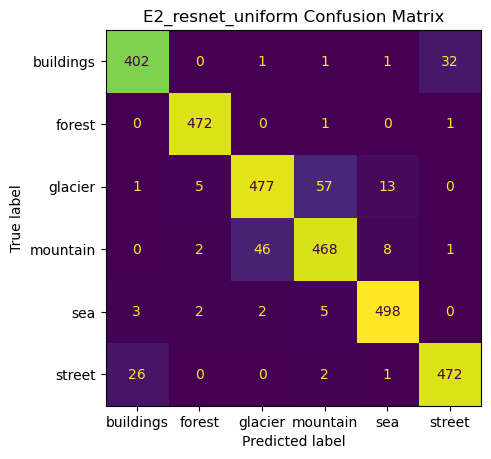

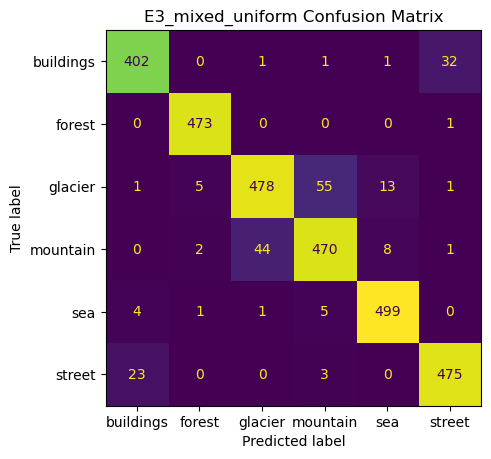

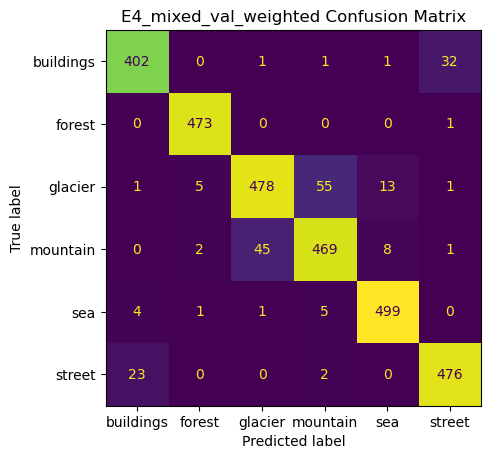

In [67]:
#Confusion Matrix
for tag, info in ensembles.items():
    cm = info["cm"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names)
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f"{tag} Confusion Matrix")
    plt.tight_layout()
    plt.show()


### Problem 3 Summary table & Discussion

| ID | Ensemble Name           | Members                                                  | Weighting Scheme              | Test Acc | Mean Per-Class Acc | Worst Per-Class Acc |
|----|-------------------------|----------------------------------------------------------|-------------------------------|---------:|-------------------:|--------------------:|
| E1 | CNN-only uniform        | `cnn_best`                                              | Uniform soft voting (1 model) | 0.8683   | 0.871              | 0.754              |
| E2 | ResNet-only uniform     | `resnet_R5_layer4`, `resnet_R8_full`, `resnet_R9_full`, `resnet_R10_full` | Uniform soft voting (1/4 each) | 0.9297   | 0.931              | 0.863              |
| E3 | Mixed CNN+ResNet uniform| `cnn_best` + the 4 ResNets above                         | Uniform soft voting (1/5 each) | 0.9323   | 0.934              | 0.864              |
| E4 | Mixed val-acc weighted  | Same 5 models as E3                                     | Soft voting, val-acc weighted | 0.9323   | 0.934              | 0.864              |

In total, ensembling clearly helped both overall accuracy and class-wise stability compared to individual models. The single best ResNet-18 model (R10) reached a top accuracy of about 0.93, which the mixed ensembles (E3 and E4) pushed this to 0.9323. The gain in accuracy is modest, but more important is that the ensemble reduced variability across classes.

The CNN baseline (E1) was much weaker overall (0.8683 Test accuracy) and particularly struggled on the glacier (0.75) and buildings/sea (see confusion matrix), while the ResNet-only ensemble (E2) already raised glacier accuracy to about ~0.86 and pushed other classes above 0.89. The mixed ensembles (E3/E4) further improved the weakest classes. Glacier and Mountain both went up slightly, and street/sea became extremely reliable.

The confusion matrices show that most of the remianing errors are confusions between glaciers and mountains, which are to be expected as they are mostly visually similar in nature. What I do know now is that Ensembling doesn't completely remove these confusions, but it noticeably reduces scattered mistakes (buildings -> streets/sea -> glacier) that show up in the single CNN/individual ResNets. In that sense, combining the models makes the predictions more stable.

The biggest takeaway is that model diversity seems to matter more than the precise weighting scheme. The ResNet only uniform ensemble (E2) already improves slightly over the best single ResNet, meaning that small architectural/hyperparameter differences between R5, R8, R9, and R10 are enough to average out some distinctive errors. On the other hand, the mixed ensembles (E3 and E4) perform the best overall, which indicates that adding a different architecture like my custom CNN introduced extra diversity that helps on edge cases, even though the CNN is weaker on its own.

Between the two Ensemble strategies I chose (uniform vs validation accuracy-weighted soft voting), there is essentially no difference in performance, with E3 and E4 having the identical test accuracy. This make sense, because the four ResNets I chose have very similar validation accuracies, so the learned weights end up close to uniform anyway. In this setting, the simple uniform mixed ensemble (E3) is the most effective and easiest to justify, giving the highest accuracy/best worst-class performance without needing any tuning of weights after the fact.


# Reflection on Project

This project has shown me that ***model diversity*** is one of the easiest ways to gain robustness and extra accuracy on an already high-performing model. My custom CNN alone could learn the dataset reasonably well (I am happy I reformatted the architecture after the first 9 poor runs), but a pretrained ResNet-18 with fine-tuning generalized better, striking my custom model out the field and getting a home-run. This is especially prevalant when I unfroze the deeper layers and added mild regularization. Combining several ResNet variants and mixing the CNN with them made predictions more stable across classes, reducing the weird class-specific failiures. The ensembles didn't radically change the accuracy as much but they consistently improved the worst per-class accuracies, which is a stronger signal of robust generalization than a single best model. 